In [46]:
import numpy as np
import matplotlib.pyplot as plt
#import copy

# Model Definitions

In [47]:
original = {
    "conv1":   {"kernel": 3, "in": 3,  "out": 32, "dims": 224},  
    "conv2":   {"kernel": 3, "in": 32, "out": 16, "dims": 112},
    "conv31":  {"kernel": 1, "in": 16, "out": 16, "dims": 56},
    "conv32":  {"kernel": 3, "in": 16, "out": 32, "dims": 56},
    "conv33":  {"kernel": 1, "in": 32, "out": 32, "dims": 56},
    "conv34":  {"kernel": 3, "in": 32, "out": 64, "dims": 56},
    "conv41":  {"kernel": 1, "in": 64, "out": 32, "dims": 28},
    "conv42":  {"kernel": 3, "in": 32, "out": 64, "dims": 28},
    "conv43":  {"kernel": 1, "in": 64, "out": 32, "dims": 28},
    "conv44":  {"kernel": 3, "in": 32, "out": 64, "dims": 28},
    "conv45":  {"kernel": 1, "in": 64, "out": 32, "dims": 28},
    "conv46":  {"kernel": 3, "in": 32, "out": 64, "dims": 28},
    "linear1": {"in": 64, "out": 16},
    "linear2": {"in": 16, "out": 2},
}

In [48]:
aimet_no_padding = {
    "conv1":   {"kernel": 3,      "in": 3,  "out": 12, "dims": 230},  
    "conv20":  {"kernel": (3, 1), "in": 12, "out": 24, "dims": 114},
    "conv21":  {"kernel": (1, 3), "in": 24, "out": 16, "dims": 114},
    "conv31":  {"kernel": 1,      "in": 16, "out": 16, "dims": 56},
    "conv320": {"kernel": (3, 1), "in": 16, "out": 16, "dims": 56},
    "conv321": {"kernel": (1, 3), "in": 16, "out": 32, "dims": 56},
    "conv33":  {"kernel": 1,      "in": 32, "out": 32, "dims": 54},
    "conv340": {"kernel": (3, 1), "in": 32, "out": 42, "dims": 54}, # ori 32, 32
    "conv341": {"kernel": (1, 3), "in": 42, "out": 64, "dims": 54}, # ori 32, 64
    "conv41":  {"kernel": 1,      "in": 64, "out": 30, "dims": 26}, # ori 64, 32
    "conv42":  {"kernel": 3,      "in": 30, "out": 60, "dims": 26}, # ori 62, 64
    "conv43":  {"kernel": 1,      "in": 60, "out": 32, "dims": 24}, # ori 64, 32
    "conv440": {"kernel": (3, 1), "in": 32, "out": 42, "dims": 24}, # ori 32, 48
    "conv441": {"kernel": (1, 3), "in": 42, "out": 58, "dims": 24}, # ori 48, 64
    "conv45":  {"kernel": 1,      "in": 58, "out": 32, "dims": 22}, # ori 64, 32
    "conv460": {"kernel": (3, 1), "in": 32, "out": 20, "dims": 22}, # ori 32, 16 
    "conv461": {"kernel": (1, 3), "in": 20, "out": 64, "dims": 22}, # ori 16, 64
    "linear1": {"in": 64, "out": 32},
    "linear2": {"in": 32, "out": 2},
}

In [49]:
balanced = {
    "conv1":   {"kernel": 3, "in": 3,  "out": 8,  "dims": 224},  
    "conv2":   {"kernel": 3, "in": 8,  "out": 16, "dims": 112},
    "conv31":  {"kernel": 1, "in": 16, "out": 16, "dims": 56},
    "conv32":  {"kernel": 3, "in": 16, "out": 32, "dims": 56},
    "conv41":  {"kernel": 1, "in": 32, "out": 32, "dims": 28},
    "conv42":  {"kernel": 3, "in": 32, "out": 64, "dims": 28},
    "conv51":  {"kernel": 1, "in": 64, "out": 32, "dims": 14},
    "conv52":  {"kernel": 3, "in": 32, "out": 64, "dims": 14},
    "conv53":  {"kernel": 1, "in": 64, "out": 32, "dims": 14},
    "conv54":  {"kernel": 3, "in": 32, "out": 64, "dims": 14},
    "conv55":  {"kernel": 1, "in": 64, "out": 32, "dims": 14},
    "conv56":  {"kernel": 3, "in": 32, "out": 64, "dims": 14},
    "linear1": {"in": 64, "out": 16},
    "linear2": {"in": 16, "out": 2},
}

# Function to compute MAC and Weights

In [50]:
def compute_macs_and_weights(model):
    for k in model.keys():
        if "conv" in k:
            if type(model[k]["kernel"]) == tuple:
                model[k].update({"mac": 
                    (model[k]["kernel"][0]*model[k]["kernel"][1]) * model[k]["in"] * model[k]["out"] * (model[k]["dims"]**2)})
                model[k].update({"weights": 
                    (model[k]["kernel"][0]*model[k]["kernel"][1]) * model[k]["in"] * model[k]["out"]})
            elif type(model[k]["kernel"]) == int:
                model[k].update({"mac": (model[k]["kernel"]**2) * model[k]["in"] * model[k]["out"] * (model[k]["dims"]**2)})
                model[k].update({"weights": (model[k]["kernel"]**2) * model[k]["in"] * model[k]["out"]})
            else:
                print("Wrong model definition")
        elif "linear" in k:
            model[k].update({"mac": model[k]["in"] * model[k]["out"]})
            model[k].update({"weights": model[k]["in"] * model[k]["out"]})
        else:
            print("Wrong layer definition")

    model_macs = {k: model[k]["mac"]  for k in model.keys()}
    total_macs = np.array([v for v in model_macs.values()]).sum()
    model_weights = {k: model[k]["weights"]  for k in model.keys()}
    total_weights = np.array([v for v in model_weights.values()]).sum()

    return {
        "layers": model,
        "macs": model_macs,
        "total_macs": total_macs,
        "weights": model_weights,
        "total_weights": total_weights,
    }

In [51]:
original_ops = compute_macs_and_weights(original)
aimet_no_padding_ops = compute_macs_and_weights(aimet_no_padding)
balanced_ops = compute_macs_and_weights(balanced)

In [52]:
print(f'Original model: \n\tMACs = {original_ops["total_macs"]}\n\tWeights = {original_ops["total_weights"]}')
print(f'Aimet model: \n\tMACs = {aimet_no_padding_ops["total_macs"]}\n\tWeights = {aimet_no_padding_ops["total_weights"]}')
print(f'Balanced model: \n\tMACs = {balanced_ops["total_macs"]}\n\tWeights = {balanced_ops["total_weights"]}')

Original model: 
	MACs = 225592352
	Weights = 92288
Aimet model: 
	MACs = 113200752
	Weights = 59128
Balanced model: 
	MACs = 67839008
	Weights = 88184


# Plot MACs and Weights Per Layer

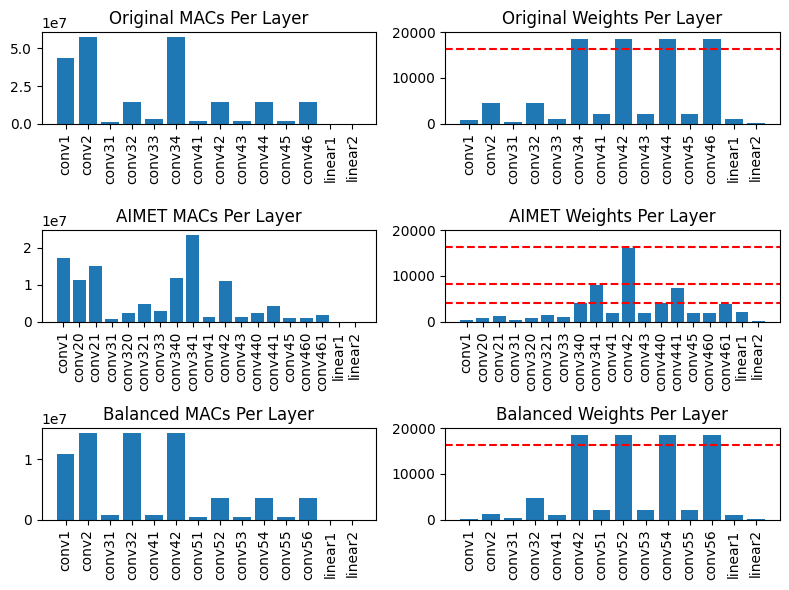

In [53]:
fig, ax = plt.subplots(3, 2, figsize=(8,6))

######################## Original ########################
plt.subplot(3, 2, 1)
ax[0, 0].bar(list(original_ops["layers"].keys()), list(original_ops["macs"].values()))
ax[0, 0].set_xticks(list(original_ops["layers"].keys()))
ax[0, 0].set_xticklabels(list(original_ops["layers"].keys()), rotation=90)
ax[0, 0].set_title("Original MACs Per Layer")

plt.subplot(3, 2, 2)
plt.axhline(y=16384, color='r', linestyle='--')
plt.axhline(y=32768, color='r', linestyle='--')
plt.ylim([0, 20000])
ax[0, 1].bar(list(original_ops["layers"].keys()), list(original_ops["weights"].values()))
ax[0, 1].set_xticks(list(original_ops["layers"].keys()))
ax[0, 1].set_xticklabels(list(original_ops["layers"].keys()), rotation=90)
ax[0, 1].set_title("Original Weights Per Layer")

######################## AIMET ########################
plt.subplot(3, 2, 3)
ax[1, 0].bar(list(aimet_no_padding_ops["layers"].keys()), list(aimet_no_padding_ops["macs"].values()))
ax[1, 0].set_xticks(list(aimet_no_padding_ops["layers"].keys()))
ax[1, 0].set_xticklabels(list(aimet_no_padding_ops["layers"].keys()), rotation=90)
ax[1, 0].set_title("AIMET MACs Per Layer")

plt.subplot(3, 2, 4)
plt.axhline(y=16384, color='r', linestyle='--')
plt.axhline(y=16384/2, color='r', linestyle='--')
plt.axhline(y=16384/4, color='r', linestyle='--')
plt.ylim([0, 20000])
ax[1, 1].bar(list(aimet_no_padding_ops["layers"].keys()), list(aimet_no_padding_ops["weights"].values()))
ax[1, 1].set_xticks(list(aimet_no_padding_ops["layers"].keys()))
ax[1, 1].set_xticklabels(list(aimet_no_padding_ops["layers"].keys()), rotation=90)
ax[1, 1].set_title("AIMET Weights Per Layer")

######################## Balanced ########################
plt.subplot(3, 2, 5)
ax[2, 0].bar(list(balanced_ops["layers"].keys()), list(balanced_ops["macs"].values()))
ax[2, 0].set_xticks(list(balanced_ops["layers"].keys()))
ax[2, 0].set_xticklabels(list(balanced_ops["layers"].keys()), rotation=90)
ax[2, 0].set_title("Balanced MACs Per Layer")

plt.subplot(3, 2, 6)
plt.axhline(y=16384, color='r', linestyle='--')
plt.axhline(y=32768, color='r', linestyle='--')
plt.ylim([0, 20000])
ax[2, 1].bar(list(balanced_ops["layers"].keys()), list(balanced_ops["weights"].values()))
ax[2, 1].set_xticks(list(balanced_ops["layers"].keys()))
ax[2, 1].set_xticklabels(list(balanced_ops["layers"].keys()), rotation=90)
ax[2, 1].set_title("Balanced Weights Per Layer")

plt.tight_layout()
plt.show()

In [54]:
for k, v in aimet_no_padding_ops["weights"].items():
    print(f'{k:<10} {v}')

conv1      324
conv20     864
conv21     1152
conv31     256
conv320    768
conv321    1536
conv33     1024
conv340    4032
conv341    8064
conv41     1920
conv42     16200
conv43     1920
conv440    4032
conv441    7308
conv45     1856
conv460    1920
conv461    3840
linear1    2048
linear2    64
